In [270]:
import pandas as pd
import numpy as np
from numpy import asarray
from sklearn import preprocessing
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn import datasets, linear_model
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from os import getcwd
from os import chdir
from os import environ
import altair as alt
import seaborn as sns
import re
from sklearn.linear_model import LinearRegression
environ['KMP_DUPLICATE_LIB_OK']='True'
chdir('/Users/Amanda/Desktop/milestone_2')

In [274]:
def normalized_data(df, columnname):
    data_series = pd.to_numeric(df[columnname])
    xx = data_series/data_series.mean()
    df[columnname + '_norm'] = xx
    return df

def conv_to_num(df):
    dfn = pd.DataFrame()

    for each in df:
        try: 
            dfn[each] =  pd.to_numeric(df[each])
        except:
            dfn[each] = df[each]
    return dfn

def add_time_dummy(df):
    df['Time'] = np.arange(len(df.index))
    return df

def choose_park(df, fullParkName):
    df = df.loc[df['ParkName'] == fullParkName].copy()
    return df

##lag by 12 to predict same month next year

def add_lag(df, column, num_lag):
    df[column + '_lag'] = df[column].shift(num_lag)
    return df

def to_new_datetime(df, yearcol, monthcol):
    df['Date'] = pd.to_datetime(df[[yearcol, monthcol]].assign(DAY=1))
    return df

def MSE_MAPE(y_true, y_pred):
    MSE = 'MSE: ' + str(mean_squared_error(y_true, y_pred))
    MAPE = 'MAPE: ' + str(mean_absolute_percentage_error(y_true, y_pred))
    r2 = 'R2: ' + str(metrics.r2_score(y_true, y_pred))
    RMSE = 'RMSE: ' + str((mean_squared_error(y_true, y_pred)**.5))
    exp_var = 'Explained Variance: ' + str(explained_variance_score(y_true, y_pred))
    return MSE, MAPE, r2, RMSE, exp_var

def drop_2020_data(df):
    df = df.drop(df[(pd.to_numeric(df['Year'])==2020)].index, inplace = True)
    return df

#clean DF for supervised learning algorithms to drop categorical data, regular values
def columns_for_sup_learn_reg(df):
    reg_df =  df[['RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'RecreationVisits_lag', 'Google_Searches_lag']]
    return reg_df

#clean DF for supervised learning algorithms to drop categorical data, normalized values
def columns_for_sup_learn_norm(df):
    reg_df =  df[['RecreationVisits_norm', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'RecreationVisits_norm', 'Time', 'RecreationVisits_norm_lag', 'Google_Searches_norm_lag']]
    return reg_df


def smooth_column(df, columnName):
    windowSize = 4
    df['smoothed_RV']=df.columnName.rolling(window=windowSize, center = True).mean()
    
def cross_val(model, X, y, folds):
    scores = cross_val_score(model, X, y, cv = folds)
    return scores, scores.mean(), scores.std()


**Read in Park and Google Trends Data**

In [199]:
trendDF=pd.read_csv('assets/NPS_with_trends.csv',dtype=str)
display(len(trendDF))
trendDF =  trendDF[['ParkName', 'UnitCode', 'Region', 'State',
       'Year', 'Month', 'RecreationVisits', 'NonRecreationVisits',
       'RecreationHours', 'NonRecreationHours', 'ConcessionerLodging',
       'ConcessionerCamping', 'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays','Google_Searches']]



12839

In [622]:
# display(trendDF.ParkName.unique())

**Choose a park. Working with Specific Park Data**

In [552]:
npDF = choose_park(trendDF, 'Zion National Park')

**Clean and Manipulate Data**

In [553]:
drop_2020_data(npDF)
add_time_dummy(npDF)
add_lag(npDF, 'RecreationVisits', 12)
add_lag(npDF, 'Google_Searches', 1)
to_new_datetime(npDF, 'Year', 'Month')
normalized_data(npDF, 'RecreationVisits')
normalized_data(npDF, 'Google_Searches')
add_lag(npDF, 'RecreationVisits_norm', 12)
add_lag(npDF, 'Google_Searches_norm', 1)
# display(npDF.head())

,ParkName,UnitCode,Region,State,Year,Month,RecreationVisits,NonRecreationVisits,RecreationHours,NonRecreationHours,...,MiscellaneousOvernightStays,Google_Searches,Time,RecreationVisits_lag,Google_Searches_lag,Date,RecreationVisits_norm,Google_Searches_norm,RecreationVisits_norm_lag,Google_Searches_norm_lag
12635,Zion National Park,ZION,Intermountain,UT,2005,1,63566,1860,336564,1860,...,0,41,0,NaN,NaN,2005-01-01,0.226029,0.830292,NaN,NaN
12636,Zion National Park,ZION,Intermountain,UT,2005,2,70260,1680,386795,1680,...,0,52,1,NaN,41,2005-02-01,0.249832,1.053053,NaN,0.830292
12637,Zion National Park,ZION,Intermountain,UT,2005,3,195530,1860,1357342,1860,...,505,69,2,NaN,52,2005-03-01,0.695270,1.397321,NaN,1.053053
12638,Zion National Park,ZION,Intermountain,UT,2005,4,230366,1800,1680595,1800,...,1216,69,3,NaN,69,2005-04-01,0.819141,1.397321,NaN,1.397321
12639,Zion National Park,ZION,Intermountain,UT,2005,5,283547,1860,1944717,1860,...,2301,74,4,NaN,69,2005-05-01,1.008243,1.498576,NaN,1.397321
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12834,Zion National Park,ZION,Intermountain,UT,2021,8,466928,1860,3105093,1860,...,1551,54,187,535322,77,2021-08-01,1.660313,1.093556,1.903510,1.559329
12835,Zion National Park,ZION,Intermountain,UT,2021,9,483180,1800,3076210,1800,...,1655,58,188,497443,54,2021-09-01,1.718103,1.174560,1.768819,1.093556
12836,Zion National Park,ZION,Intermountain,UT,2021,10,469379,1860,2902495,1860,...,1765,51,189,429604,58,2021-10-01,1.669029,1.032802,1.527596,1.174560
12837,Zion National Park,ZION,Intermountain,UT,2021,11,308560,1800,1932994,1800,...,1152,44,190,230180,51,2021-11-01,1.097185,0.891045,0.818479,1.032802


**Look at Correlation between variables**

In [554]:
display(npDF.columns)

Index(['ParkName', 'UnitCode', 'Region', 'State', 'Year', 'Month',
       'RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'RecreationVisits_lag',
       'Google_Searches_lag', 'Date', 'RecreationVisits_norm',
       'Google_Searches_norm', 'RecreationVisits_norm_lag',
       'Google_Searches_norm_lag'],
      dtype='object')

In [555]:
regrDF = npDF[['RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging',
       'TentCampers', 'RVCampers', 'Backcountry', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'RecreationVisits_lag', 'Google_Searches_lag']].copy()

In [556]:
for each in regrDF.columns:
    regrDF[each]=regrDF[each].astype(float)

In [557]:
matrix = regrDF.corr()

display(matrix)

,RecreationVisits,NonRecreationVisits,RecreationHours,NonRecreationHours,ConcessionerLodging,TentCampers,RVCampers,Backcountry,MiscellaneousOvernightStays,Google_Searches,Time,RecreationVisits_lag,Google_Searches_lag
RecreationVisits,1.000000,0.240312,0.993855,0.240312,0.761038,0.924719,0.756834,0.528685,0.746980,0.741706,0.423901,0.968192,0.838946
NonRecreationVisits,0.240312,1.000000,0.248565,1.000000,0.272012,0.270827,0.222748,0.206157,0.258845,0.063261,0.016570,0.242769,0.106740
RecreationHours,0.993855,0.248565,1.000000,0.248565,0.809596,0.953207,0.794594,0.587145,0.789691,0.720630,0.388346,0.970408,0.821810
NonRecreationHours,0.240312,1.000000,0.248565,1.000000,0.272012,0.270827,0.222748,0.206157,0.258845,0.063261,0.016570,0.242769,0.106740
ConcessionerLodging,0.761038,0.272012,0.809596,0.272012,1.000000,0.872925,0.771366,0.691291,0.792887,0.463824,0.064212,0.759854,0.592513
TentCampers,0.924719,0.270827,0.953207,0.270827,0.872925,1.000000,0.828322,0.690801,0.838402,0.622362,0.229573,0.921603,0.743617
RVCampers,0.756834,0.222748,0.794594,0.222748,0.771366,0.828322,1.000000,0.636038,0.705026,0.500889,0.087654,0.749525,0.586581
Backcountry,0.528685,0.206157,0.587145,0.206157,0.691291,0.690801,0.636038,1.000000,0.769647,0.197241,-0.130364,0.537120,0.280855
MiscellaneousOvernightStays,0.746980,0.258845,0.789691,0.258845,0.792887,0.838402,0.705026,0.769647,1.000000,0.447345,0.051965,0.754015,0.522072
Google_Searches,0.741706,0.063261,0.720630,0.063261,0.463824,0.622362,0.500889,0.197241,0.447345,1.000000,0.426199,0.737480,0.865935


<AxesSubplot:>

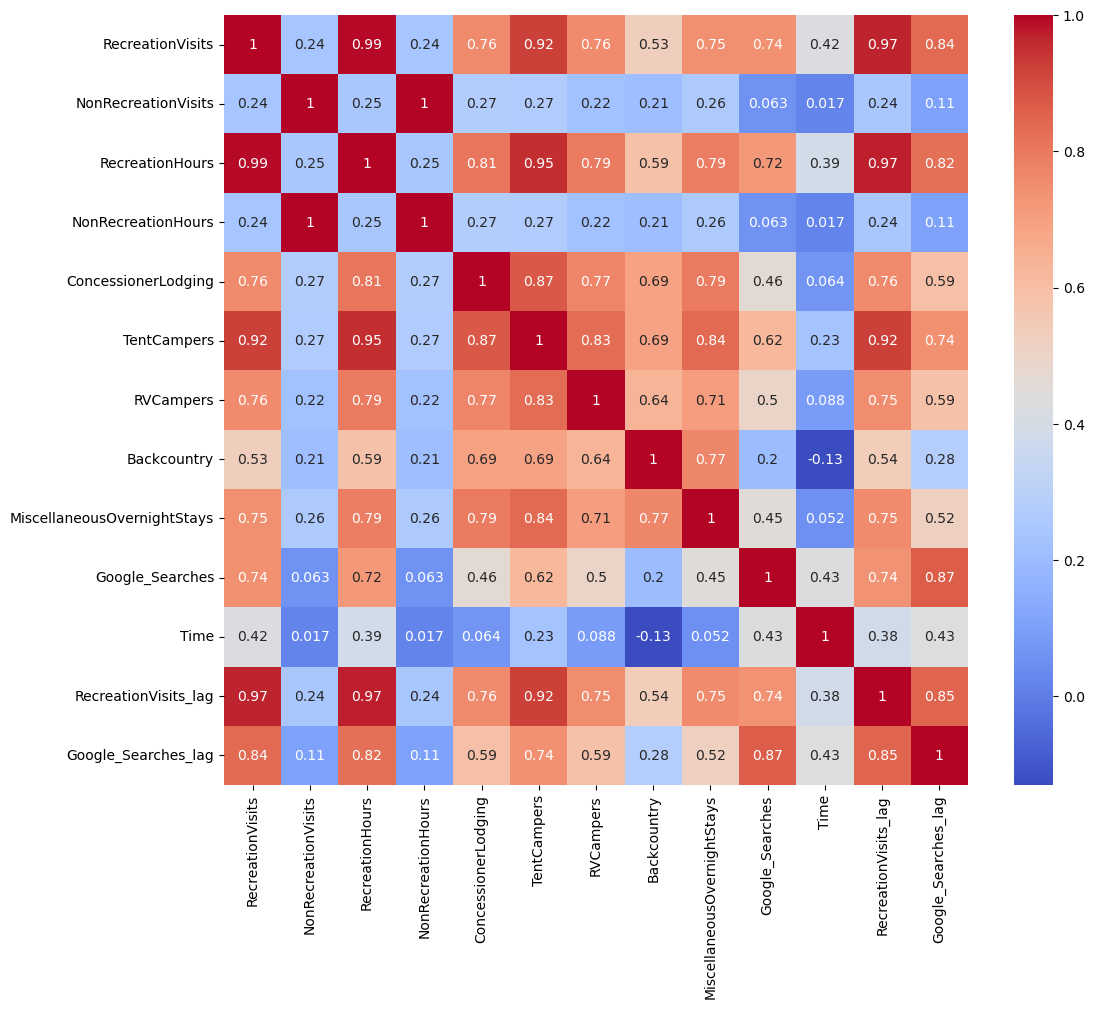

In [558]:
plt.figure(figsize = (12,10))
sns.heatmap(matrix, cmap='coolwarm', annot=True)

**Time Plot with Linear Regression Line via Altair**

In [559]:
scatter = alt.Chart(npDF).mark_line(point=True).encode(
    x='Time:Q',
    y= alt.Y('RecreationVisits:Q', axis = alt.Axis(title = 'Recreation Visits'))

)
scatter+scatter.transform_regression('Time', 'RecreationVisits').mark_line(color='red')

alt.LayerChart(...)

**Plot Original Data Against Lag Data with Regression Line via Altair** 
<br>
We can see that there is a correlation between the visits that occurred on a previous month.

In [560]:
scatter = alt.Chart(npDF).mark_line(point=True).encode(
    x= alt.X('RecreationVisits_lag:Q',axis = alt.Axis(title = 'Recreation Visits with Lag')),
    y= alt.Y('RecreationVisits:Q', axis = alt.Axis(title = 'Recreation Visits'))

)
scatter+scatter.transform_regression('RecreationVisits_lag', 'RecreationVisits').mark_line(color='red')

alt.LayerChart(...)

**Linear Regression Sklearn Time vs Recreation Visits**

In [561]:
X = npDF.loc[:, ['Time']]
y = npDF.loc[:, 'RecreationVisits']

reg = LinearRegression()
reg.fit(X,y)

npDF['y_pred'] = pd.Series(reg.predict(X), index=X.index)
# display(zionDF.head())

**Linear Regression Time vs Recreation Visits Scores**

In [562]:
y_true = npDF['RecreationVisits']
y_pred = npDF['y_pred']

MSE_MAPE(y_true, y_pred)

('MSE: 19352220347.2338',
 'MAPE: 0.8055691364230283',
 'R2: 0.17969195641250568',
 'RMSE: 139112.25807682727',
 'Explained Variance: 0.17969195641250568')

**Linear Regression Plot**

In [563]:
pred_scatter = alt.Chart(npDF).mark_circle().encode(
    x='Time:Q',
    y= 'RecreationVisits:Q',

)

pred_line = alt.Chart(npDF).mark_line(color = 'red').encode(
    x='Time:Q',
    y= 'y_pred:Q',
)


pred_scatter + pred_line

alt.LayerChart(...)

**Linear Regression Sklearn Recreation Visits vs Recreation Visits with Lag**

In [564]:
X_lag = npDF.loc[:, ['RecreationVisits_lag']]
y_lag = npDF.loc[:, 'RecreationVisits']
X_lag.dropna(inplace=True)
y_lag,X_lag = y_lag.align(X_lag, join='inner')

reg2 = LinearRegression()
reg2.fit(X_lag, y_lag)

npDF['y_pred_lag'] = pd.Series(reg2.predict(X_lag), index=X_lag.index)


# print(zionDF['y_pred_lag'])
# print(zionDF['RecreationVisits'])

**Linear Regression Scores for prediction of Recreation visits from Recreation Visits with a lag**

In [565]:
y_pred_lag = np.array(npDF['y_pred_lag'])
y_true_lag = np.array(npDF['RecreationVisits'])



lagnan = ~np.isnan(y_pred_lag)
y_pred_lag = y_pred_lag[lagnan]
y_true_lag = y_true_lag[lagnan]



# y_true_lag = zionDF['RecreationVisits']
# y_pred_lag = zionDF['y_pred_lag']

lr_score = MSE_MAPE(y_true_lag, y_pred_lag)
print(lr_score)

('MSE: 1509049998.9807167', 'MAPE: 0.10706066827893465', 'R2: 0.9373956019621511', 'RMSE: 38846.49275006325', 'Explained Variance: 0.9373956019621511')


**Linear Regression Plot**

In [566]:
pred_scatter_lag = alt.Chart(npDF).mark_circle().encode(
    x='RecreationVisits_lag:Q',
    y= 'RecreationVisits:Q',

)

pred_line_lag = alt.Chart(npDF).mark_line(color = 'red').encode(
    x='RecreationVisits_lag:Q',
    y= 'y_pred_lag:Q',
)


pred_scatter_lag + pred_line_lag

alt.LayerChart(...)

**Graph of Predictions (red) versus true visits (orange)**

In [567]:
line1 = alt.Chart(npDF).mark_line(color='orange').encode(
    x='Time:Q',
    y= 'RecreationVisits:Q',

)

line2 = alt.Chart(npDF).mark_line(color = 'red').encode(
    x='Time:Q',
    y= 'y_pred_lag:Q',
)


line1+line2

alt.LayerChart(...)

**Random Forest Regressor**

In [568]:
npDF = npDF.drop(['y_pred', 'y_pred_lag'], axis=1)

In [569]:
display(npDF.columns)

Index(['ParkName', 'UnitCode', 'Region', 'State', 'Year', 'Month',
       'RecreationVisits', 'NonRecreationVisits', 'RecreationHours',
       'NonRecreationHours', 'ConcessionerLodging', 'ConcessionerCamping',
       'TentCampers', 'RVCampers', 'Backcountry',
       'NonRecreationOvernightStays', 'MiscellaneousOvernightStays',
       'Google_Searches', 'Time', 'RecreationVisits_lag',
       'Google_Searches_lag', 'Date', 'RecreationVisits_norm',
       'Google_Searches_norm', 'RecreationVisits_norm_lag',
       'Google_Searches_norm_lag'],
      dtype='object')

**First use all features for the Random Forest Regressor**

In [570]:
all_feat_df = columns_for_sup_learn_reg(npDF).copy()
# display(all_feat_df.columns)

all_feat_df.dropna(axis=0, inplace = True)
# all_feat_df = all_feat_df.drop(['RecreationHours', 'NonRecreationOvernightStays','Backcountry', 'ConcessionerCamping', 'NonRecreationHours', 'NonRecreationVisits'  ], axis = 1)
labels = np.array(all_feat_df['RecreationVisits'])

# display(all_feat_df.columns)
features = all_feat_df.drop('RecreationVisits', axis=1)

feature_list = list(features.columns)

features = np.array(features)

In [571]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [572]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 42)
rfr.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=500, random_state=42)

**Random Forest Regressor Scores (used all features)**

In [573]:
predictions = rfr.predict(test_features)

MSE_MAPE(test_labels, predictions)

('MSE: 478098756.89492863',
 'MAPE: 0.03730233753254204',
 'R2: 0.9805879811675187',
 'RMSE: 21865.469510050058',
 'Explained Variance: 0.9814980742866282')

**Cross-Validation for All Features**

In [574]:
scores, mean, stand_d = cross_val(rfr, train_features, train_labels, 10)
print(scores)
print(mean)
print(stand_d)

[0.99252494 0.98751118 0.9963044  0.9919917  0.99043397 0.97045236
 0.9868638  0.99045528 0.98900271 0.97499568]
0.9870536012336775
0.007667692685146767


Think we may be getting some data leakage due to the high influence of RecreationHours as seen in the feature importance

**Feature Importance for All Features**

In [575]:
important_list = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RecreationHours      Importance: 0.96
Variable: RecreationVisits_lag Importance: 0.03
Variable: TentCampers          Importance: 0.01
Variable: NonRecreationVisits  Importance: 0.0
Variable: NonRecreationHours   Importance: 0.0
Variable: ConcessionerLodging  Importance: 0.0
Variable: ConcessionerCamping  Importance: 0.0
Variable: RVCampers            Importance: 0.0
Variable: Backcountry          Importance: 0.0
Variable: NonRecreationOvernightStays Importance: 0.0
Variable: MiscellaneousOvernightStays Importance: 0.0
Variable: Google_Searches      Importance: 0.0
Variable: Time                 Importance: 0.0
Variable: Google_Searches_lag  Importance: 0.0


In [576]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

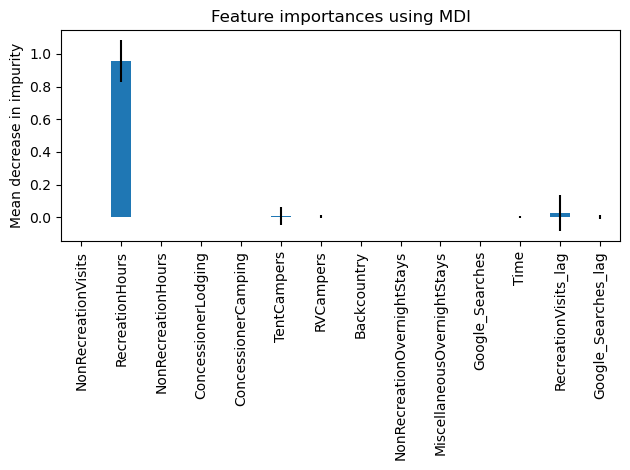

In [577]:
forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Edited code to remove RecreationHours and re-test**

In [578]:
# display(all_feat_df)
mod_feat_df = all_feat_df.drop(['RecreationHours'], axis=1)# 'NonRecreationOvernightStays','Backcountry', 'ConcessionerCamping', 'NonRecreationHours', 'NonRecreationVisits'  ], axis = 1)
labels = np.array(mod_feat_df['RecreationVisits'])

# display(all_feat_df.columns)
features = mod_feat_df.drop('RecreationVisits', axis=1)

feature_list = list(features.columns)

features = np.array(features)

In [579]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [580]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 42)
rfr.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=500, random_state=42)

In [581]:
important_list = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RecreationVisits_lag Importance: 0.74
Variable: TentCampers          Importance: 0.14
Variable: RVCampers            Importance: 0.06
Variable: Google_Searches_lag  Importance: 0.02
Variable: MiscellaneousOvernightStays Importance: 0.01
Variable: Google_Searches      Importance: 0.01
Variable: Time                 Importance: 0.01
Variable: NonRecreationVisits  Importance: 0.0
Variable: NonRecreationHours   Importance: 0.0
Variable: ConcessionerLodging  Importance: 0.0
Variable: ConcessionerCamping  Importance: 0.0
Variable: Backcountry          Importance: 0.0
Variable: NonRecreationOvernightStays Importance: 0.0


Much better. Now we're going to drop the scores that are zero (along with RecreationHours)

**Remove all features that are zero**

In [582]:
# display(all_feat_df)
final_feat_df = all_feat_df.drop(['RecreationHours','NonRecreationOvernightStays','Backcountry', 'ConcessionerCamping','ConcessionerLodging', 'NonRecreationHours', 'NonRecreationVisits'], axis = 1)
labels = np.array(final_feat_df['RecreationVisits'])

# display(all_feat_df.columns)
features = final_feat_df.drop('RecreationVisits', axis=1)

feature_list = list(features.columns)

features = np.array(features)

In [583]:
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.25, random_state = 42)

In [584]:
rfr = RandomForestRegressor(n_estimators = 500, random_state = 42)
rfr.fit(train_features, train_labels)

RandomForestRegressor(n_estimators=500, random_state=42)

In [585]:
predictions = rfr.predict(test_features)

rfr_score = MSE_MAPE(test_labels, predictions)
print(rfr_score)

('MSE: 1731477600.128009', 'MAPE: 0.0854329035460574', 'R2: 0.9296976298369852', 'RMSE: 41611.02738611496', 'Explained Variance: 0.9296995976784995')


In [586]:
scores, mean, stand_d = cross_val(rfr, train_features, train_labels, 10)
print(scores)
print(mean)
print(stand_d)

[0.95836788 0.94948945 0.97834881 0.96822327 0.95138416 0.92179031
 0.94879849 0.97875625 0.90422057 0.94848384]
0.9507863045293566
0.022190008908696438


In [587]:
important_list = list(rfr.feature_importances_)

feature_importances = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list)]

feature_importances = sorted(feature_importances, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances];

Variable: RecreationVisits_lag Importance: 0.74
Variable: TentCampers          Importance: 0.14
Variable: RVCampers            Importance: 0.06
Variable: Google_Searches_lag  Importance: 0.02
Variable: MiscellaneousOvernightStays Importance: 0.01
Variable: Google_Searches      Importance: 0.01
Variable: Time                 Importance: 0.01


In [619]:
importances = rfr.feature_importances_
std = np.std([tree.feature_importances_ for tree in rfr.estimators_], axis=0)

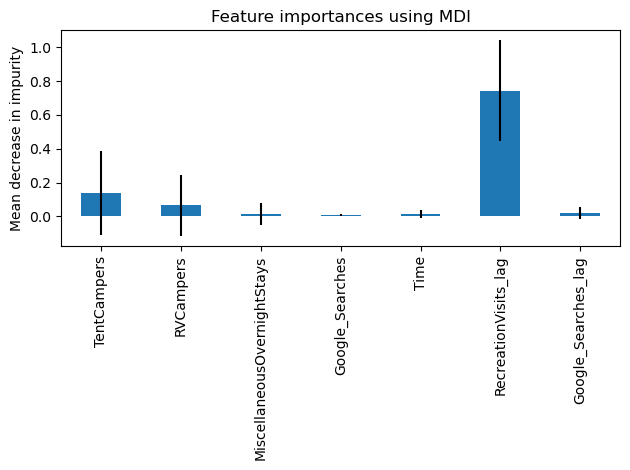

In [604]:
forest_importances = pd.Series(importances, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Gradiant Boosting Regressor**

In [611]:
GB_reg = GradientBoostingRegressor(random_state=42)
GB_reg.fit(train_features, train_labels)

GradientBoostingRegressor(random_state=42)

**Gradiant Boosting Scores**

In [612]:
GB_predictions = GB_reg.predict(test_features)

gb_score = MSE_MAPE(test_labels, GB_predictions)
print(gb_score)

('MSE: 1399075444.1396663', 'MAPE: 0.08093523318796249', 'R2: 0.9431939981478135', 'RMSE: 37404.21692990867', 'Explained Variance: 0.9432619750700028')


**Gradient Boosting Cross-Validation**

In [613]:
cross_val(GB_reg, train_features, train_labels, 10)

(array([0.97659932, 0.94244774, 0.98405062, 0.98130693, 0.94528958,
        0.9327508 , 0.95876438, 0.97468123, 0.91785124, 0.96172893]),
 0.9575470768459887,
 0.021239954359368214)

**Gradient Boosting Feature Importance**

In [621]:
important_list_gb = list(GB_reg.feature_importances_)

feature_importances_gb = [(feature, round(importance, 2)) for feature, importance in zip(feature_list, important_list_gb)]

feature_importances_gb = sorted(feature_importances_gb, key = lambda x: x[1], reverse = True)

[print('Variable: {:20} Importance: {}'.format(*pair)) for pair in feature_importances_gb];

Variable: RecreationVisits_lag Importance: 0.77
Variable: TentCampers          Importance: 0.16
Variable: Time                 Importance: 0.03
Variable: RVCampers            Importance: 0.02
Variable: MiscellaneousOvernightStays Importance: 0.01
Variable: Google_Searches      Importance: 0.01
Variable: Google_Searches_lag  Importance: 0.01


In [618]:
importances_gb = GB_reg.feature_importances_
# std_gb = np.std([boost.feature_importances_ for boost in GB_reg.estimators_], axis=0)

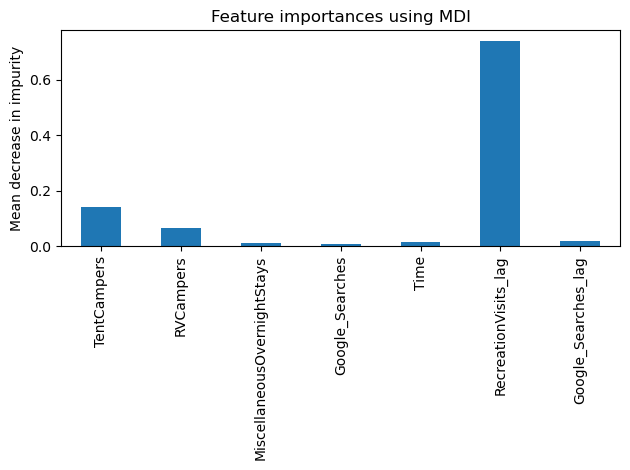

In [620]:
GB_reg_importances = pd.Series(importances_gb, index=feature_list)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

**Dataframe of all Model Scores**

In [593]:
scoreList = lr_score, rfr_score, gb_score

print(lr_score)
# listList = lr_list, rfr_list, gb_list
fitType = ['Linear Regression', 'Random Forest Regressor', 'Gradiant Boosting Regressor']

scoreDF=pd.DataFrame()
for name, score in zip(fitType, scoreList):
    wordlist = []
    numlist = []
    print(name)

    for word in score:
        word, number = tuple(word.split(': '))
        wordlist += [word]
        numlist += [round(float(number),4)]
    
    scoreDict = dict(zip(wordlist, numlist))
    scoreDict['Model']= name
    scoreDict={k:[v] for k,v in scoreDict.items()}
    scoreDF = pd.concat([scoreDF,pd.DataFrame(scoreDict)])

scoreDF=scoreDF.set_index('Model')

display(scoreDF)
# print(word)
# print(number)
        # range(listList += [word.split()[-1]]
# print(lr_list)
# rfr_score
# gb_score

('MSE: 1509049998.9807167', 'MAPE: 0.10706066827893465', 'R2: 0.9373956019621511', 'RMSE: 38846.49275006325', 'Explained Variance: 0.9373956019621511')
Linear Regression
Random Forest Regressor
Gradiant Boosting Regressor


,MSE,MAPE,R2,RMSE,Explained Variance
Model,,,,,
Linear Regression,1.509050e+09,0.1071,0.9374,38846.4928,0.9374
Random Forest Regressor,1.731478e+09,0.0854,0.9297,41611.0274,0.9297
Gradiant Boosting Regressor,1.399075e+09,0.0809,0.9432,37404.2169,0.9433
